# AIPI 590 - xAI | Assignment #04

## Explainable Techniques II : PDP, ICE, and ALE plots.

### Shaila Güereca

PENDIENTE

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shailajgg/AIPI590_Explainable_AI/blob/main/Explainable_Techniques_I/Explainable_Resnet_lime.ipynb)


## Table of Contents
1. [Setup and data loading](#setup)
2. [Exploratory analysis](#eda)
3. [Model training](#model)
4. [Partial dependence plots (PDP)](#pdp)
5. [Individual conditional expectation (ICE)](#ice)
6. [Accumulated local effects (ALE)](#ale)


In [1]:
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from pdpbox import pdp
from sklearn.inspection import PartialDependenceDisplay
import shap
from alepython.ale import ale_plot

Today we will be using the Airbnb NYC 2019 Dataset Analysis Plan. This dataset contains pricing, location, and property details from NYC Airbnb listings for 2019.

We will have the following numerical variables: 

##### Numerical Variables

- price

- minimum_nights

- number_of_reviews

- reviews_per_month

- calculated_host_listings_count

- availability_365


##### Categorical Variables

- neighbourhood_group

- room_type

- location (latitude/longitude)

In [3]:
# Set plotting style
plt.style.use("seaborn")
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv("AB_NYC_2019.csv")

# Basic data cleaning
df = df.dropna()
df["log_price"] = np.log1p(df["price"])  # Log transform price

# Code was generated using Claude 3.5 Sonnet on 02/05/25 at 4:20 p.m.

In [4]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nFeature Information:")
print(df.info())
print("\nNumerical Features Summary:")
print(df.describe())

# Display sample
print("\nSample Records:")
print(df.head())

# Code was generated using Claude 3.5 Sonnet on 02/05/25 at 4:25 p.m.

Dataset Shape: (38821, 17)

Feature Information:
<class 'pandas.core.frame.DataFrame'>
Index: 38821 entries, 0 to 48852
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38821 non-null  int64  
 1   name                            38821 non-null  object 
 2   host_id                         38821 non-null  int64  
 3   host_name                       38821 non-null  object 
 4   neighbourhood_group             38821 non-null  object 
 5   neighbourhood                   38821 non-null  object 
 6   latitude                        38821 non-null  float64
 7   longitude                       38821 non-null  float64
 8   room_type                       38821 non-null  object 
 9   price                           38821 non-null  int64  
 10  minimum_nights                  38821 non-null  int64  
 11  number_of_reviews               38821 non-null  i

## 2. Exploratory Analysis <a id='eda'></a>

Let's first understand the relationships between our features.

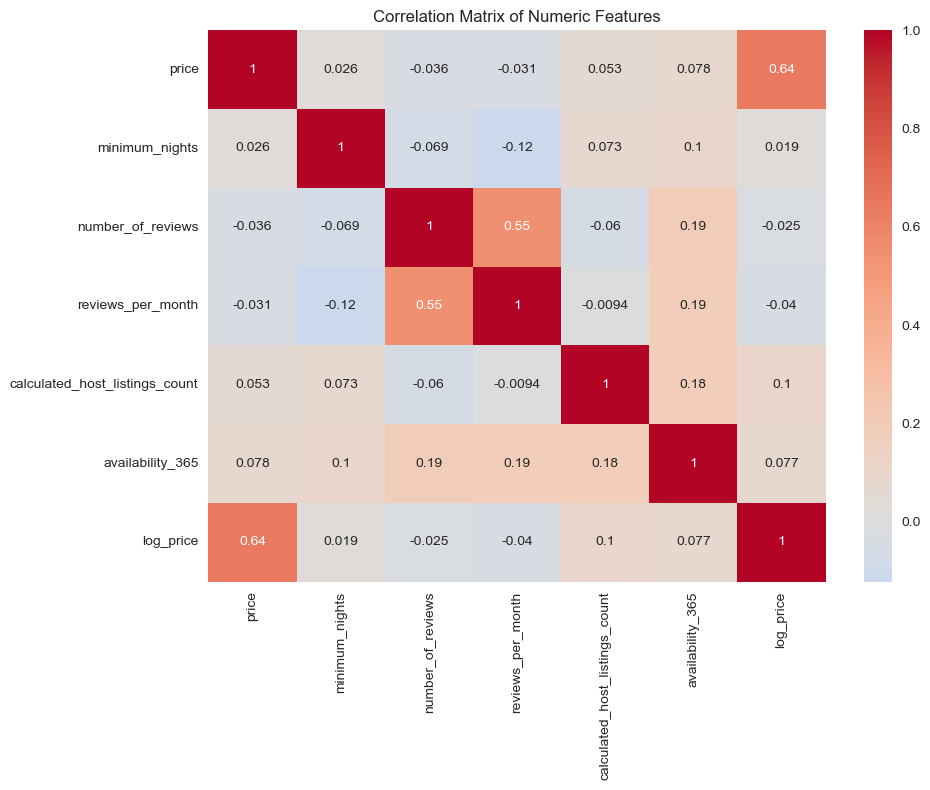


Key correlations with log_price:
minimum_nights: 0.019
number_of_reviews: -0.025
reviews_per_month: -0.040
calculated_host_listings_count: 0.101
availability_365: 0.077


In [5]:
# Select numeric columns for correlation analysis
numeric_cols = [
    "price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "log_price",
]
correlation_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# Print key correlations
print("\nKey correlations with log_price:")
for col in numeric_cols:
    if col != "log_price" and col != "price":
        corr = correlation_matrix.loc["log_price", col]
        print(f"{col}: {corr:.3f}")

# Code was generated using Claude 3.5 Sonnet on 02/05/25 at 4:35 p.m.

If we examine the correlation between our numerical variables, we can see that, at first glance, there are no particularly strong relationships among them. The strongest correlation is between reviews per month and number of reviews, at 0.55. This makes sense since these two variables are both related to reviews, and in the long run, a property with more monthly reviews will naturally accumulate a higher total number of reviews.

On the other hand, the strongest negative correlation we observe is between minimum nights and number of reviews, with a correlation of -0.069, essentially negligible. However, the negative sign could suggest that properties requiring longer stays tend to receive fewer reviews, as fewer guests may need extended accommodations.

## 3. Model Training <a id='model'></a>

In [6]:
# Prepare features for modeling
features = [
    "room_type",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

# Create dummy variables for categorical features
df_model = pd.get_dummies(df[features + ["log_price"]], columns=["room_type"])

# Split features and target
X = df_model.drop("log_price", axis=1)
y = df_model["log_price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Code was generated using Claude 3.5 Sonnet on 02/05/25 at 4:40 p.m.

RandomForestRegressor(random_state=42)

## 4. Partial Dependence Plots (PDP) <a id='pdp'></a>

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model [Paper, 2001](https://jerryfriedman.su.domains/ftp/trebst.pdf)

* It is the average of the lines of an ICE plot!
* Can show the relationship between a feature and the target. Show the marginal effect of a feature on the predicted outcome.

Source: https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=zS19oKUE780n&uniqifier=1


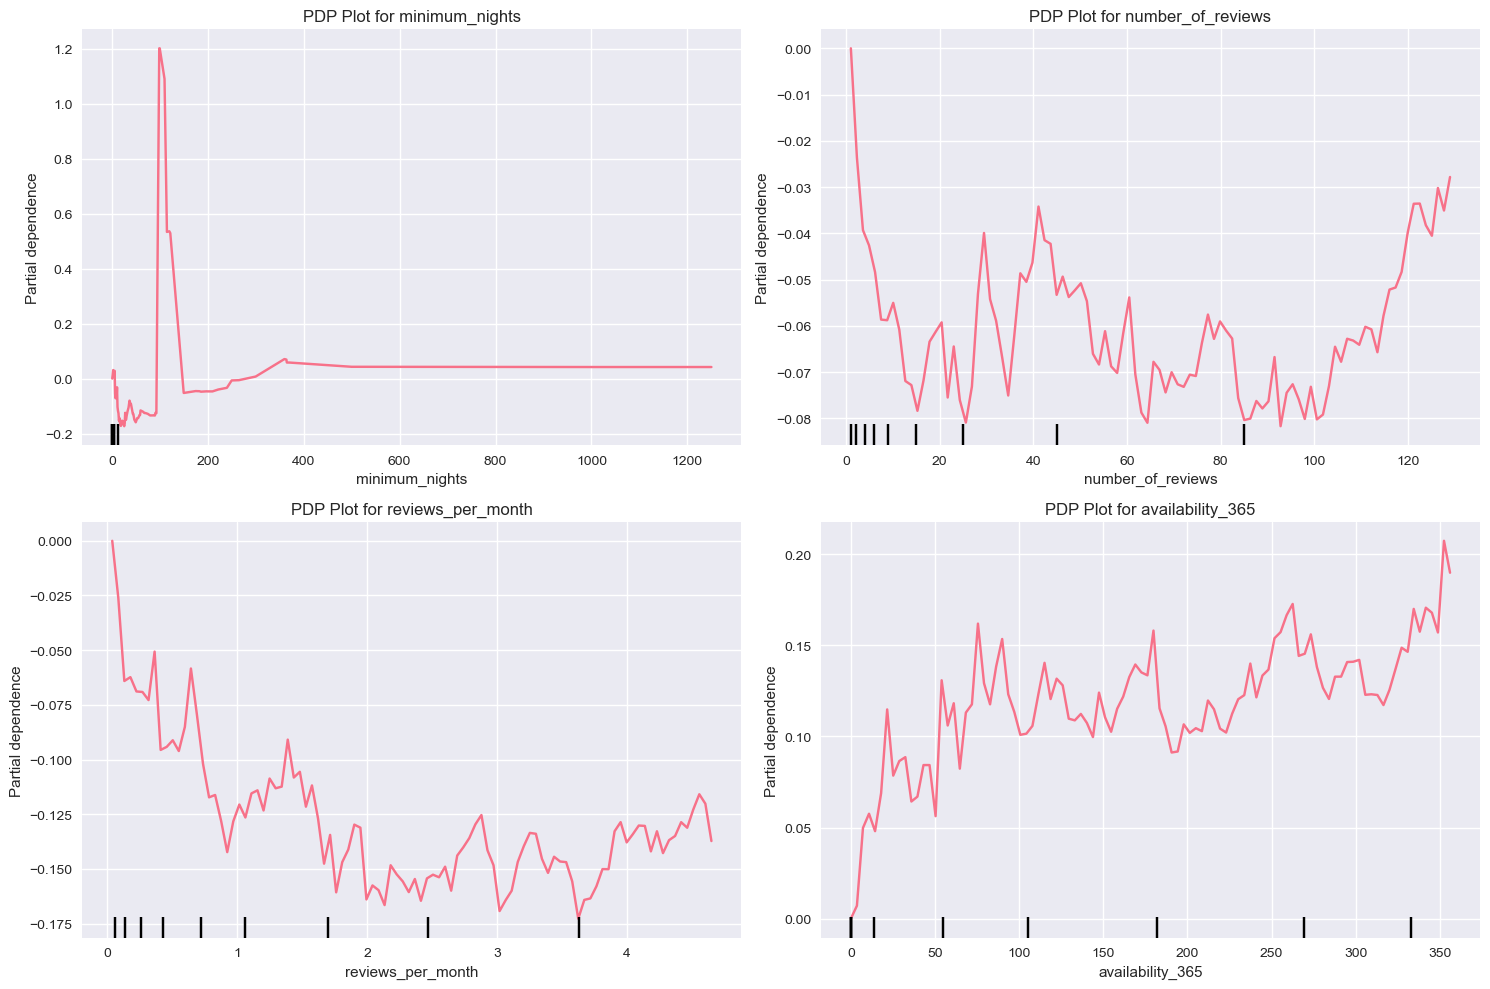

In [7]:
def create_pdp_plots(model, X_train, features):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, feature in enumerate(features):
        PartialDependenceDisplay.from_estimator(
            model, X_train, [feature], ax=axes[idx], kind="average", centered=True
        )
        axes[idx].set_title(f"PDP Plot for {feature}")

    plt.tight_layout()
    plt.show()


# Create PDP plots for numeric features
numeric_features = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
]
create_pdp_plots(model, X_train, numeric_features)

# Code was generated using Claude 3.5 Sonnet on 02/05/25 at 4:42 p.m.

## Explanation & Findings 

Next, we will analyze the marginal effect of the following variables in relation to Airbnb prices:  

- **Minimum nights:** The effect remains stable when the minimum stay is greater than 400 nights, which makes sense since it is unlikely that many listings enforce such long-term stay requirements. However, around 100 minimum nights, we observe a noticeable increase in price, potentially driven by a common factor among listings that require stays of 1 to 2 months—perhaps catering to remote workers or long-term visitors. In the short-term range, where most bookings are concentrated, we see a slight decrease in price. Initially, a minimum of 1 night has a high impact (possibly due to cleaning fees that are spread differently depending on stay length), but this impact stabilizes close to zero.  

- **Number of reviews:** There is more variability in this case, primarily showing a negative marginal effect. Between 20 and 80 reviews, we observe high volatility, which might be explained by a mix of both positive and negative reviews. However, once a listing surpasses 100 reviews, the negative effect starts to correct. This could indicate that properties with a high number of reviews—potentially Superhost listings—benefit from positive feedback, allowing them to maintain higher prices.  

- **Reviews per month:** We observe a slight downward trend in the marginal effect on price, though the impact remains minimal. Properties with more frequent reviews tend to have slightly lower prices, possibly because users leave reviews for listings that offer good value for money.  

- **Availability 365:** The relationship between availability and price shows a generally positive trend, meaning listings with higher availability tend to have higher prices. However, there are fluctuations within the range. When a listing is available year-round, its partial dependence effect reaches 0.20, which might be explained by the fact that these listings can capture high-demand periods, leading to an increased average price.  


## 5. Individual Conditional Expectation (ICE) <a id='ice'></a>


It is worth to remember that Individual Conditional Expectation (ICE) plots one line per instance that displays how the instance’s prediction changes when a feature changes [Paper, 2014](https://arxiv.org/pdf/1309.6392)

**How it Works**
1. Select instance and feature of interest
2. Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
3. Make predictions with the black box model for newly created instances
4. You now have a set of points for an instance with the feature value from the grid and the respective predictions

Source: https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=8WVOuglNdgEJ&line=9&uniqifier=1

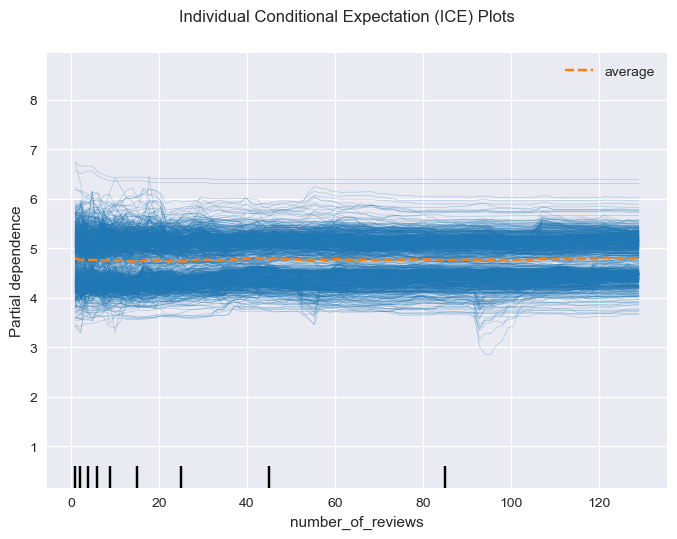

In [ ]:
# ICE plots
features2 = ["number_of_reviews"]

# Viwe ICE plots
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features2,
    kind="both",
)
plt.suptitle("Individual Conditional Expectation (ICE) Plots")
plt.subplots_adjust(top=0.9)
plt.show()

# Code for ICE part was generated using Claude 3.5 Sonnet on 02/05/25 at 4:51 p.m.

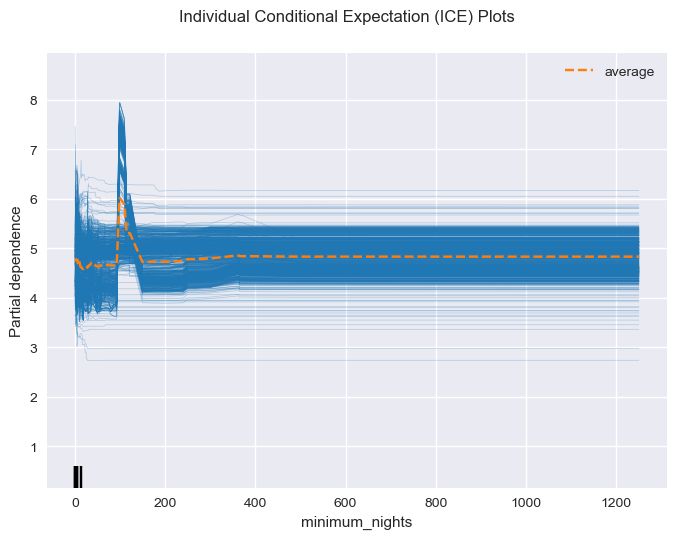

In [17]:
# ICE plots
features1 = ["minimum_nights"]

# Viwe ICE plots
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features1,
    kind="both",
)
plt.suptitle("Individual Conditional Expectation (ICE) Plots")
plt.subplots_adjust(top=0.9)
plt.show()

## Explanation & Findings 

In this section, we analyze the variables **minimum_nights** and **number_of_reviews**.  

### **Minimum Nights**  
The generated simulations align closely with the Partial Dependence Plot (PDP), showing a noticeable jump around a minimum stay of 100 nights. However, while some lines continue following a linear trend, there appear to be a few outliers with this requirement that have significantly higher prices compared to other listings with different minimum night requirements.  

### **Number of Reviews**  
For *number_of_reviews*, the range of individual lines in the ICE plot is much more dispersed compared to the PDP. Here, we observe two apparent trends: one following a dependence pattern around 4 and another starting at 6. However, at first glance, the number of reviews does not appear to have a strong impact on price.  



## 6. Accumulated Local Effects (ALE) <a id='ale'></a>

ALE plots show how features influence predictions locally.

Accumulated local effects33 describe how features influence the prediction of a machine learning model on average. ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs).

If features of a machine learning model are correlated, the partial dependence plot cannot be trusted. The computation of a partial dependence plot for a feature that is strongly correlated with other features involves averaging predictions of artificial data instances that are unlikely in reality. This can greatly bias the estimated feature effect. Imagine calculating partial dependence plots for a machine learning model that predicts the value of a house depending on the number of rooms and the size of the living area. 

Source: https://christophm.github.io/interpretable-ml-book/ale.html

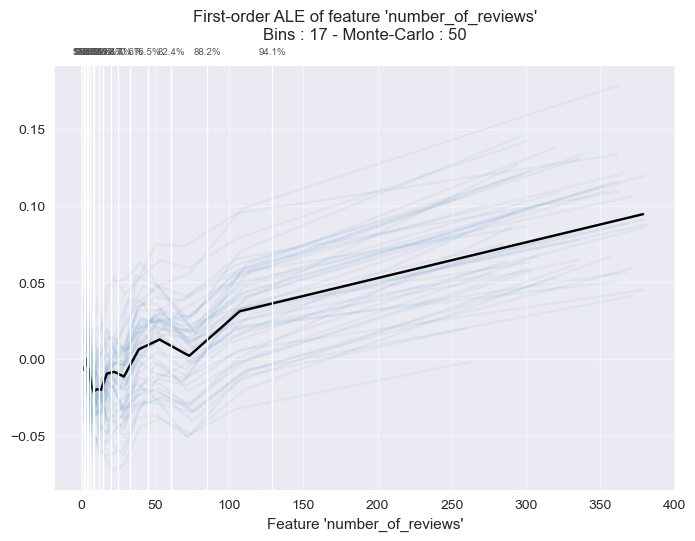

<Axes: title={'center': "First-order ALE of feature 'number_of_reviews'\nBins : 17 - Monte-Carlo : 50"}, xlabel="Feature 'number_of_reviews'">

In [9]:
# Code for ALE was generated using Claude 3.5 Sonnet on 02/05/25 at 4:51 p.m.
ale_plot(model, X_train, features=["number_of_reviews"], bins=20, monte_carlo=True)

## Explanation & Findings 

Adavantages: ALE plots are unbiased, which means they still work when features are correlated. Partial dependence plots fail in this scenario because they marginalize over unlikely or even physically impossible combinations of feature values.

Disadvantages: An interpretation of the effect across intervals is not permissible if the features are strongly correlated. ALE effects may differ from the coefficients specified in a linear regression model when features interact and are correlated. ALE plots can become a bit shaky (many small ups and downs) with a high number of intervals. Unlike PDPs, ALE plots are not accompanied by ICE curves.

Source: https://christophm.github.io/interpretable-ml-book/ale.html


### Key Findings:

2. PDP vs ALE Differences:
- PDPs show smoother relationships but may be biased due to correlations
- ALE plots reveal more local patterns and interaction effects
- Key differences in:
  * Shape of relationship for number_of_reviews
  * Magnitude of effects for availability
  * Treatment of correlated features

3. ICE Plot Insights:
- Individual variations around the average effect
- Heterogeneous effects for different instances
- Some instances show opposite trends to the general pattern

4. Impact of Feature Correlations:
- Correlations affect interpretation of PDPs
- ALE plots more reliable for correlated features
- SHAP values help quantify interaction effects
